## Analysis Notebook
This Jupyter notebook contains important plots present in the paper with relevant descriptions. The first cell contains importing of relevant packages and code, make sure dependencies are fulfilled and compatible. 

In [186]:
from my_plotting import *
from my_functions import *
sns.set_style('ticks')

#### important files
- pickled emulator, pca, and scaler
- training and validation set
- parameter set
- experimental data in relevant kinematical range
- parameter samples
- posterior samples (or just sample from the complete set)
- model values for posterior samples

In [187]:
# first decide if we are dealing with correlated setup and which model
correlated_ = True
model_ = "mve/" # or "mv5" for the 5 parameter case

In [188]:
correlated_str = "corr/" if correlated_ else "uncorr/"
param_names = ["$Q_{s0}^{2}$ (GeV²)",
               "$\gamma$",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ (mb)"] if model_ == "mv5/" else ["$Q_{s0}^{2}$ (GeV²)",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ (mb)"]
n_params = 5 if model_ == "mv5/" else 4
# all files
folder = model_ + correlated_str
exp_file = "hera_allerrors.csv"
gpe_pkl = folder+"gpe.pkl"
pca_pkl = folder+"pca.pkl"
scaler_pkl = folder+"scaler.pkl"
train_file, theta_file = model_+"training/train.dat", model_+"training/theta.dat"
train_file_val, theta_file_val = model_+"validation/train.dat", model_+"validation/theta.dat"
posterior_parameters_all_file = folder+"theta_all.dat"
train_file_post, theta_file_post = folder+"train.dat", folder+"theta.dat"
mean_model_file = folder+"mean.dat"
median_model_file = folder+"median.dat"
map_model_file = folder+"map.dat"

In [189]:
# load from files
# Emulator and emulator predictions
emulators = loadfrompickle(gpe_pkl), loadfrompickle(pca_pkl), loadfrompickle(scaler_pkl)

# emulator training
train, theta = load_training_data(train_file, theta_file)
pred, err = return_predictions(emulators, theta, correlated=correlated_)

# emulator validation
train_val, theta_val = load_training_data(train_file_val, theta_file_val)
pred_val, err_val = return_predictions(emulators, theta_val, correlated=correlated_)

# emulator and bayesian posterior validation
train_post, theta_post = load_training_data(train_file_post, theta_file_post)
cut = my_cut_array(0.0, 60.0, theta_post[:,1])
train_post, theta_post = train_post[cut], theta_post[cut]
pred_post, err_post = return_predictions(emulators, theta_post, correlated=correlated_)

# Posterior samples
posterior_parameters_all = np.vstack(np.loadtxt(posterior_parameters_all_file))

# Experimental dataframe with columns:
exp_df, exp, exp_err, xbj = load_exp(exp_file, correlated = correlated_)

# mean, median and map values
l_bounds = [0.04, 0.9, 0.5, 2.0, 12.0] if model_ == "mv5/" else [0.04, 0.5, 2.0, 12.0]
u_bounds = [0.11, 1.1, 60.0, 10.0, 18.0] if model_ == "mv5/" else [0.11, 60.0, 10.0, 18.0]
median = np.median(posterior_parameters_all, axis=0).reshape(1,-1)
mean = np.mean(posterior_parameters_all, axis=0).reshape(1,-1)
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err, correlated = correlated_), median.reshape(-1)).x
MAP = MAP.reshape(1,-1)
median_model = np.loadtxt(median_model_file)
mean_model = np.loadtxt(mean_model_file)
MAP_model = np.loadtxt(map_model_file)

/home/carlislecasuga/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/carlislecasuga/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/carlislecasuga/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.

### Training Description
The training set is generated by sampling the parameter space with a latin hypercube design. The parameter space is defined by the following parameters: $Q_{s0}^2$, $\gamma$, $e_c$, $C^{2}$, $\sigma_0/2$. The final prior bounds used in the study is a result of multiple iterations of the Bayesian sampling and each time making, what was initially, a very generous parameter space even smaller for better emulator predictions. In a latin hypercube, the parameter vectors for the model to be calculated on and the emulator to be trained on are sampled evenly across the space such that there is no redundancy in each individual parameter.

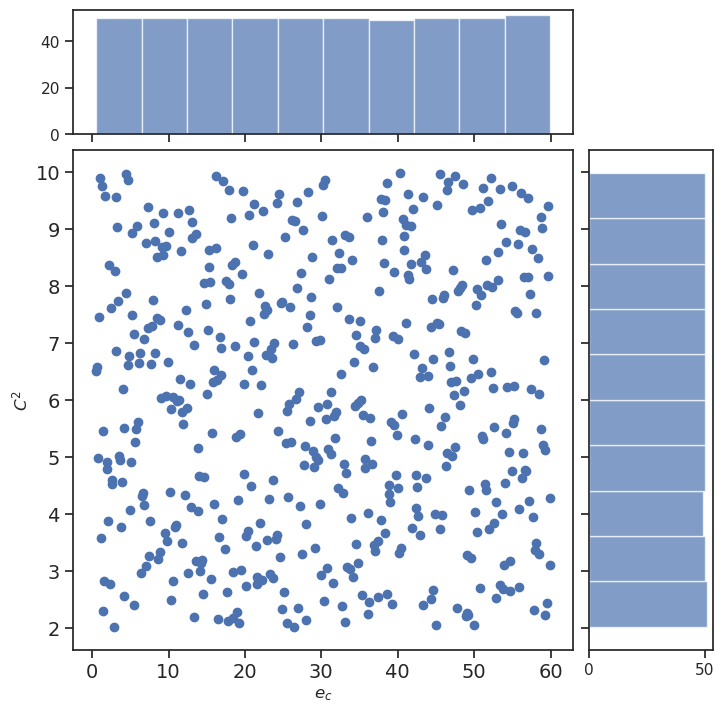

In [190]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
scatter_hist(1, 2, ax, ax_histx, ax_histy, theta, param_names)

### Emulator Validation
The following shows comparison of emulator prediction to HERA data and model calculation to a validation set of 100 parameter vectors to validate the emulator before feeding it into the bayesian sampler.

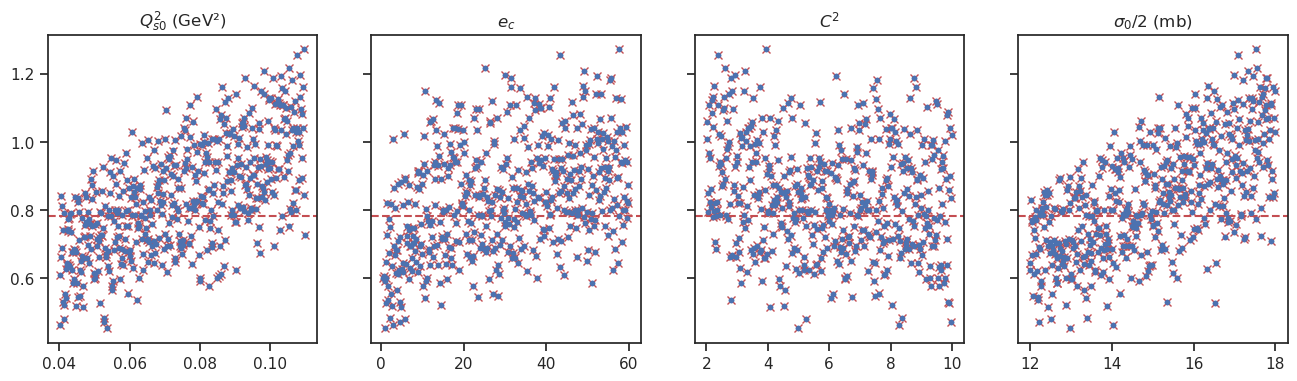

In [191]:
kp = 0
sd = np.sqrt(np.diagonal(err, axis1 = 1, axis2 = 2)) if correlated_ else err
fig, ax = plot_validation_perkp(0, pred, sd, train, exp, n_params, theta, param_names)

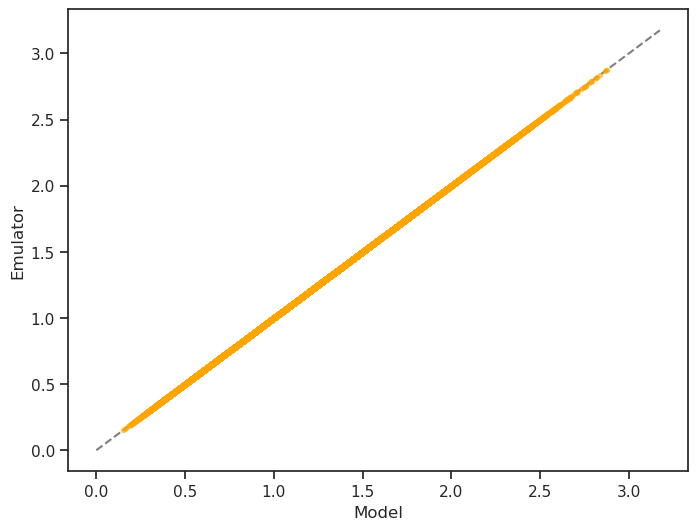

In [192]:
fig, ax = plot_diagonal(pred, train)

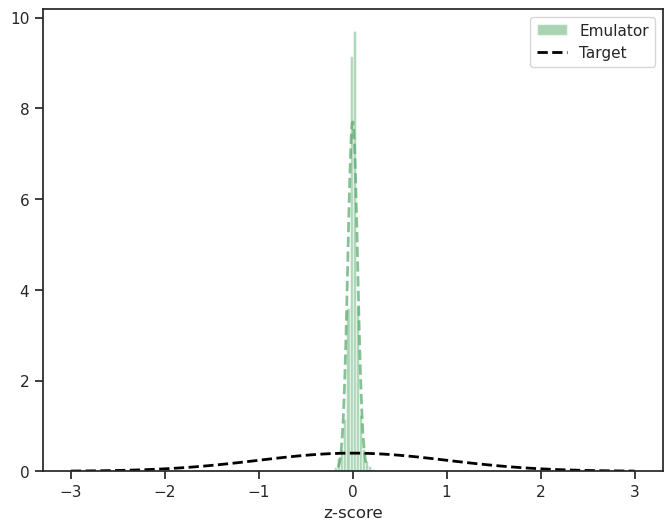

In [193]:
fig, ax = plot_zscore(pred, train, sd)

### Corner plot
Running the MCMC results to a posterior distribution describing the areas of high posterior probability. Diagonal plots of the triangle diagram are 1D projections of the posterior distribution for each parameter. The off-diagonal plots are 2D projections of the posterior distribution for each pair of parameters that show the correlation between the pair. The broken lines shows the parameter values at the posterior median, or the 50th percentile. Right after the corner plots, median and MAP values are printed for each parameter.

In [194]:
posterior_parameters_tocompare = np.vstack(np.loadtxt("../BayesianBK/run_corr/mve/plainLHS/mve_500d_uncorr_05to60_100w_mapinit_allsamples.txt", unpack = True)).T
fig2, corner = plot_corner(posterior_parameters_all, param_names)
plot_corner_tocompare(posterior_parameters_tocompare, fig2, corner)

TypeError: plot_corner() missing 1 required positional argument: 'param_names'

In [ ]:
# median
#display_median(posterior_parameters_all, param_names)
print(mean)
print(median)
print(MAP)

[[ 0.0621105  35.39164417  4.98840743 14.1182717 ]]
[[ 0.06128619 34.9184612   4.88534329 14.09257819]]
[[ 0.06075776 38.42141655  4.55131355 13.90184285]]


In [ ]:
# MAP
# display_MAP(posterior_parameters_all, param_names, l_bounds, u_bounds, emulators, exp, exp_err, correlated = correlated_)

### Posterior Validation
Next we visualize different results from sampling from the posterior and then comparing to HERA data the model calculation at the MAP/ Median values.

In [ ]:
median_emulator, median_emulator_err = return_predictions(emulators, median, correlated=correlated_)

In [ ]:
MAP_emulator, MAP_emulator_err = return_predictions(emulators, MAP, correlated=correlated_)
#display_MAP(posterior_parameters_all, param_names, l_bounds, u_bounds, emulators, exp, exp_err, correlated = correlated_)

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '4-parameter fit'}, xlabel='$x_{bj}$', ylabel='$\\sigma_r$ (mb)'>)

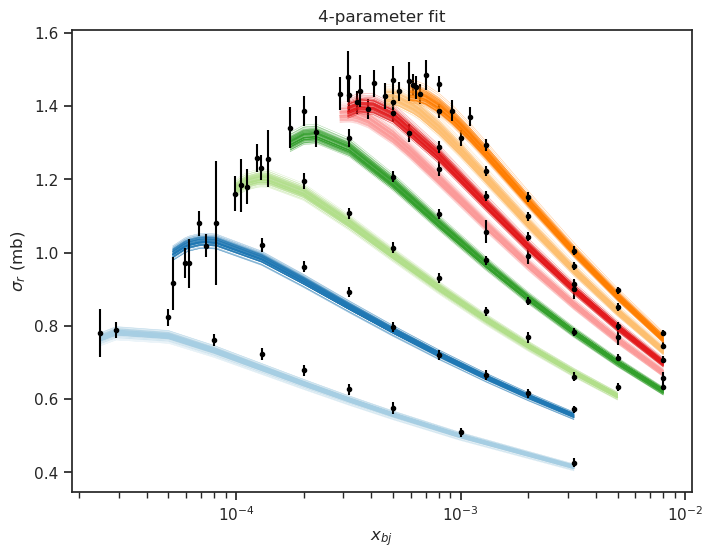

In [196]:
plot_model_vs_exp([2., 4.5, 8.5, 15.0, 22.0,  27.,  35.,  45.], 318.0, train_post, exp_df, exp_err, title_ = "{}-parameter fit".format(n_params), correlated = correlated_)
# 8.5, 15.0, 22.0,  27.,  35.,  45.

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '4-parameter fit'}, xlabel='$x_{bj}$', ylabel='$\\sigma_r$'>)

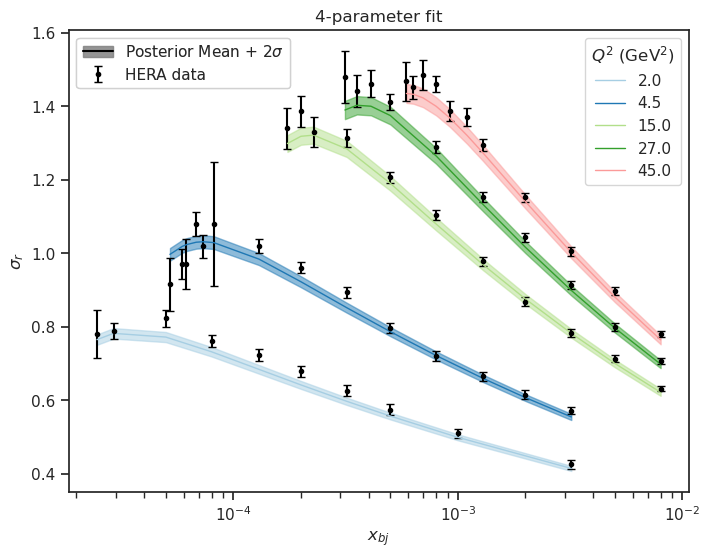

In [195]:
plot_posterior_mean_and_ub([2., 4.5, 15.0, 27., 45.], 318.0, train_post, exp_df, exp_err, title_ = "{}-parameter fit".format(n_params), correlated = correlated_)

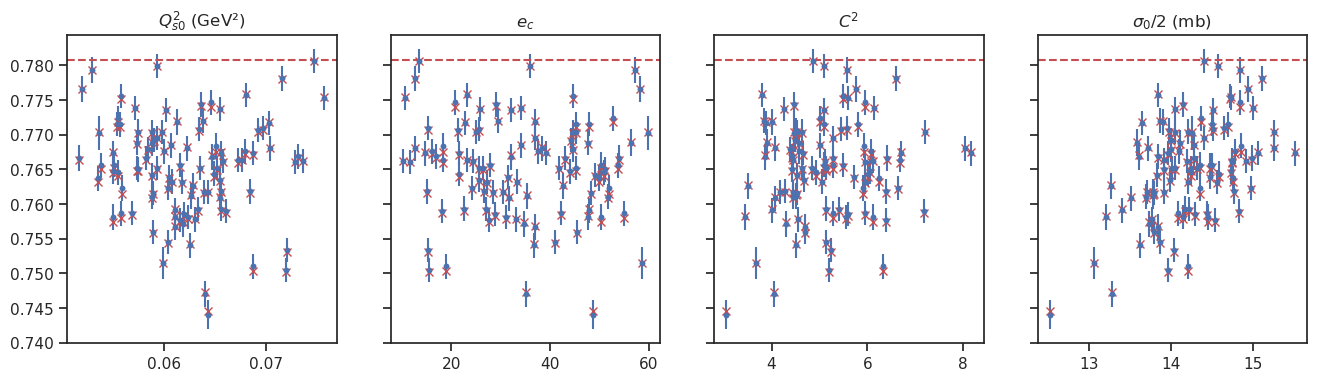

In [197]:
sd_post = np.sqrt(np.diagonal(err_post, axis1 = 1, axis2 = 2)) if correlated_ else err_post
fig, ax = plot_validation_perkp(0, pred_post, sd_post, train_post, exp, n_params, theta_post, param_names)

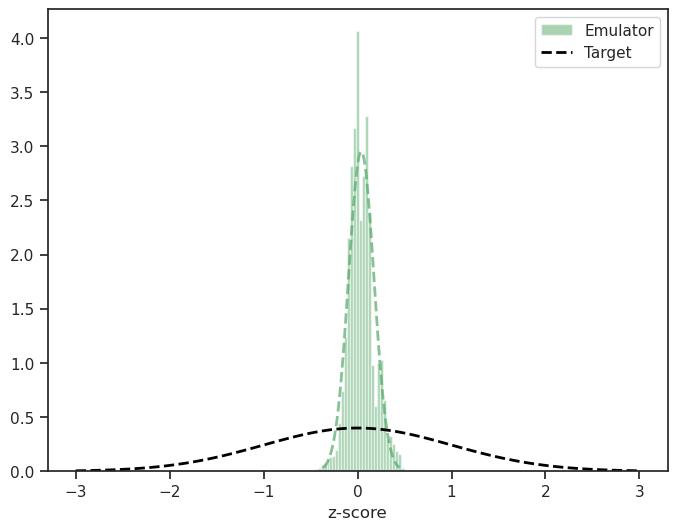

In [198]:
fig, ax = plot_zscore(pred_post, train_post, sd_post)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

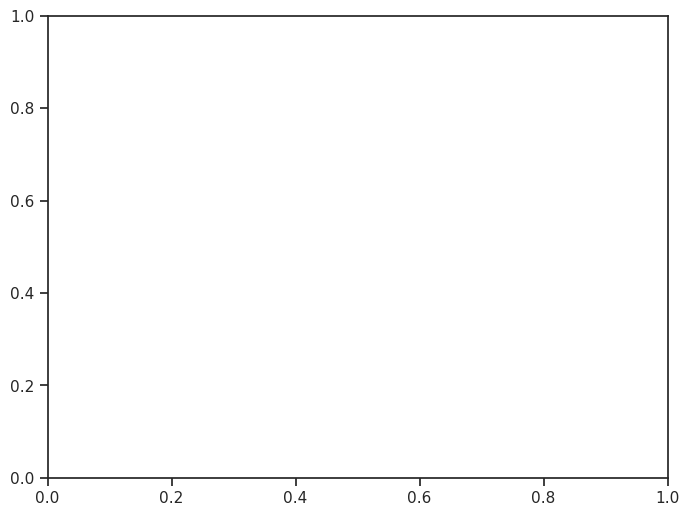

In [124]:
plot_exp_vs_map_vs_median([2., 4.5, 8.5, 10., 15., 18.,  22.,  27.,  35.,  45.], 318.0, MAP_model, exp_df, exp_err, median_model, correlated = correlated_)

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='Model', ylabel='Emulator'>)

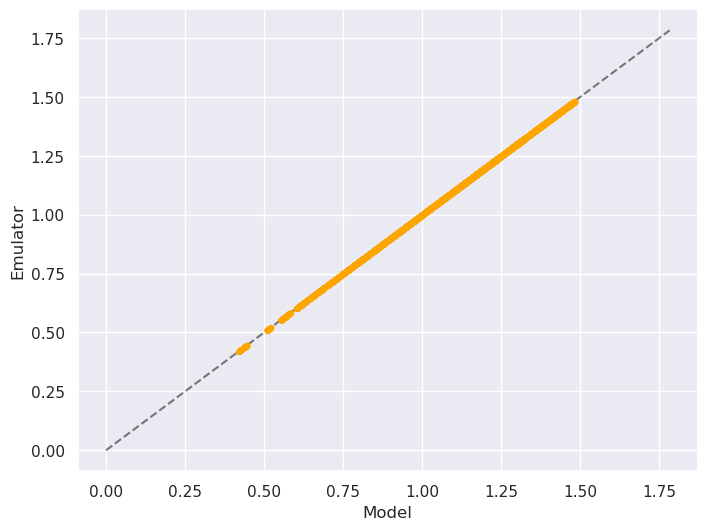

In [ ]:
plot_diagonal(pred_post, train_post)

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='Model', ylabel='Emulator'>)

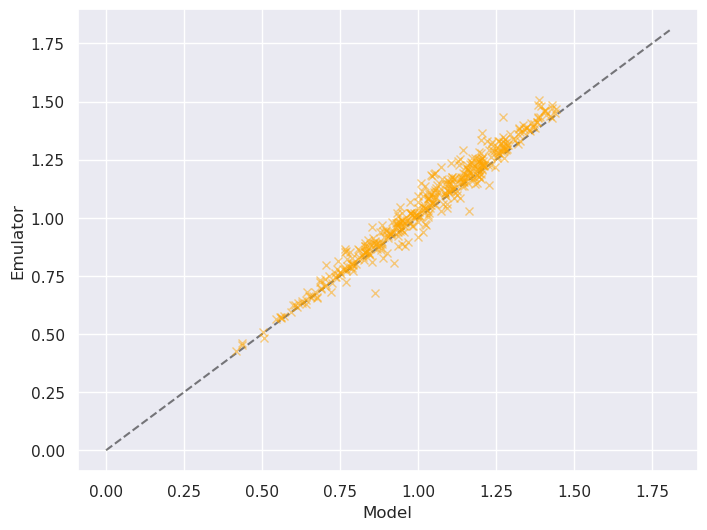

In [ ]:
# EXP vs median (model calc)
plot_diagonal_1(exp, median_model)
#diag = np.linspace(0.4, 1.5, 100)
#plt.plot(exp, mean_model, 'x')
#plt.plot(diag, diag, '--')


(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='Model', ylabel='Emulator'>)

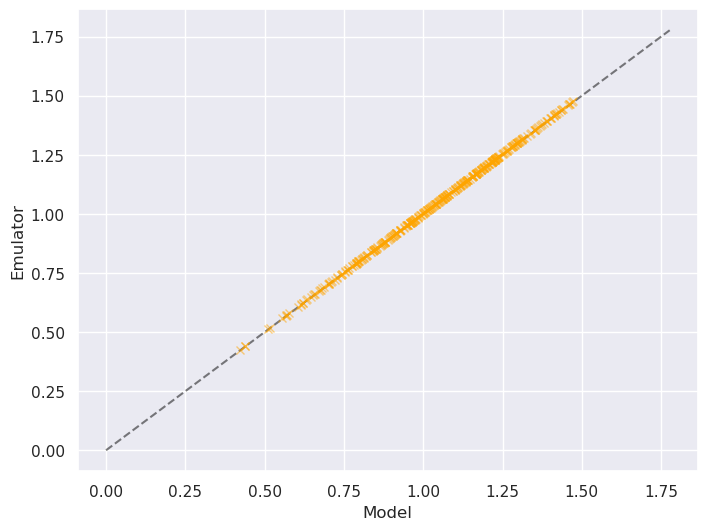

In [ ]:
# model vs emulator at median
plot_diagonal_1(median_model.reshape(403), median_emulator.reshape(403))

## Application: 2DFT Dipole Amplitude

Given the optimal parameter vector distribution, we can optimize the initial condition for the BK equation where the agreement with HERA is max. Using these "initial conditions", we can provide CGC LO prediction for observables describing pp and pA collisions at the LHC (and in the future, EIC) like particle production. One example is the 2D fourier transform of the dipole proton amplitude which can be directly calculated from the initial condition:


$$ \tilde{S}(k_{T}) = \int d²r e^{ik \cdot r} [1 - N(r)] = 2 \pi \int dr r J_0(k*r) (1 - N(r))$$

In [ ]:
# take about 1000 samples from the posterior
from hankel import HankelTransform
ht = HankelTransform(nu = 0, # order of Bessel function
                     N = 1000, # Number of steps in integration
                     h = 0.001 # Proxy for size of steps
                     ) 
n = 1000
inds = np.random.randint(len(posterior_parameters_all), size = n)
theta_post_1000 = np.array([posterior_parameters_all[i] for i in inds])
k = np.logspace(-1,1,50)
e_cs = theta_post_1000[:, 1]
Qs02s = theta_post_1000[:, 0]
sigma02s = theta_post_1000[:, -1]
gammas = theta_post_1000[:, 2] if model_ == "mv5" else np.ones(n)
sp = get_2DFT_upsd_downsd(Qs02s, gammas, e_cs, k, ht)

In [ ]:
sp_usd = sp[0]+ 2*sp[1]
sp_dsd = sp[0]- 2*sp[2]

In [ ]:
k = np.logspace(-1,1,50)
fig, ax = plt.subplots()
ax.plot(k, mv5_sp[0], 
         '--',
         linewidth = 2, 
         color = "b")
ax.fill_between(k, 
                 mv5_sp_usd, 
                 mv5_sp_dsd, 
                 alpha = 0.6, 
                 color = "b")
ax.plot(k, 
         mve_sp[0], 
         '--',
         linewidth = 2,  
         color = "r")
ax.fill_between(k, 
                 mve_sp_usd, 
                 mve_sp_dsd, 
                 alpha = 0.6,
                 color = "r")
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_xlabel('$k$ [GeV]', fontsize = 18)
ax.set_ylabel(r'$\tilde{S}_{p}(k) [GeV^{-2}]$ ', fontsize = 18) 

blue_line = Line2D([0], [0], color='b', linestyle='--', linewidth=2)
blue_patch = mpatches.Patch(color='b', alpha = 0.6)
red_line = Line2D([0], [0], color='r', linestyle='--', linewidth=2)
red_patch = mpatches.Patch(color='r', alpha = 0.6)
handles_ = [(blue_patch, blue_line),(red_patch, red_line), ]
ax.legend(handles= handles_, 
           labels = ["[$ Q_{s0}^{2}, e_{c}, C^{2}, \sigma_{0}/2, \gamma$]", "[$ Q_{s0}^{2}, e_{c}, C^{2}, \sigma_{0}/2$]"], 
           loc = "lower left") 